In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast

In [2]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [3]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [4]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [5]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [6]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

# Hub Genes

In [54]:
import pandas as pd
import numpy as np
import os
from scipy.stats import mannwhitneyu, false_discovery_control

In [55]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

#top_ccc = df[df['interactor'].astype(bool)][['f_degree_tumor', 'f_degree_normal']]
#top_ccc['sum'] = top_ccc['f_degree_tumor'] + top_ccc['f_degree_normal']
#top_ccc.sort_values(by='f_degree_tumor', ascending=False).head(20)

In [56]:
def find_files(filename, search_path):
    result = []
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

def hub_connectivities(root_only=True):
    
    if root_only:
        filename = 'hubs_connectivities_root.csv'
    else:
        #filename = 'hubs_connectivities_all.csv'
        filename = 'hubs_connectivities_hallmarks.csv'

    # Example usage:
    search_path = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'
    matches = find_files(filename, search_path)    

    pw_genes   = {}
    name_to_id = {}
    id_to_name = {}

    #with open('/home/lnemati/resources/reactome/ReactomePathways.gmt', 'r') as f:
    #    for line in f.readlines():
    #        line = line.split('\t')
    #        name_to_id[line[0]] = line[1]
    #        id_to_name[line[1]] = line[0]
    #        pw_genes[line[0]] = line[2:]
    #  
    #ndf = pd.DataFrame(columns=id_to_name.values())
    #tdf = pd.DataFrame(columns=id_to_name.values())
    
    pw_genes   = {}
    name_to_id = {}
    id_to_name = {}

    with open('/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt', 'r') as f:
        for line in f.readlines():
            line = line.split('\t')
            name_to_id[line[0]] = line[1]
            id_to_name[line[1]] = line[0]
            pw_genes[line[0]] = line[2:]

    ndf = pd.DataFrame(columns=id_to_name.values())
    tdf = pd.DataFrame(columns=id_to_name.values())

     
    if root_only:
        root_pws = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
        root_pws = root_pws['root'].map(id_to_name).unique()

        ndf = ndf[root_pws]
        tdf = tdf[root_pws]

        #ndf = pd.DataFrame(columns=root_pws)
        #tdf = pd.DataFrame(columns=root_pws)

    for match in matches:
        if '/normal/' in match:
            row = pd.read_csv(match, index_col=0).T
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            ndf = pd.concat([ndf, row])
        elif '/tumor/' in match:
            row = pd.read_csv(match, index_col=0).T
            row.index = [match.split('/')[-2]]
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            tdf = pd.concat([tdf, row])

    ndf = ndf.set_index('subtissue', drop=True)
    tdf = tdf.set_index('subtissue', drop=True)
    
    ndf = ndf.groupby('tissue').median()
    tdf = tdf.groupby('tissue').median()

    ndf['Condition'] = 'normal'
    tdf['Condition'] = 'tumor'
    
    df = pd.concat([ndf, tdf])

    # Reset index to preserve tissue information
    df = df.reset_index()
    
    # Reshape the DataFrame to a long format suitable for violin plots
    df = pd.melt(df, id_vars=['Condition', 'tissue'], var_name='Pathway', value_name='connection_strength')
    df = df.set_index('tissue')
    
    #df_long['connection_strength'] = np.log(df_long['connection_strength'])
    
    order = df.drop(columns='Condition').groupby('Pathway').mean().sort_values(by='connection_strength', ascending=False).index
    
    # Initialize an empty dictionary to store the results
    pvals = {}

    # Get unique pathways
    pathways = df['Pathway'].unique()

    # Loop through each pathway
    for pathway in pathways:
        # Subset the data for the current pathway
        subset = df[df['Pathway'] == pathway]

        # Split into normal and tumor conditions
        normal = subset[subset['Condition'] == 'normal']['connection_strength']
        tumor = subset[subset['Condition'] == 'tumor']['connection_strength']

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(normal, tumor, alternative='two-sided')

        # Store the p-value in the dictionary with pathway as the key
        pvals[pathway] = p_value

    # Convert the dictionary to a pandas Series
    pvals = pd.Series(pvals, name='pvals')
    pvals = pvals.loc[order]
    pvals.loc[order] = false_discovery_control(pvals, method='bh')

    return df, pvals

In [57]:
def find_files(filename, search_path):
    result = []
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

filename = 'hubs_connectivities_hallmarks.csv'

# Example usage:
search_path = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'
matches = find_files(filename, search_path)    

In [58]:
connect, pvals = hub_connectivities(root_only=False)

In [60]:
# Sort by median difference
#grouped = connect.groupby(['Pathway', 'Condition'])['connection_strength'].median()
#pivoted = grouped.unstack(level='Condition')
#pivoted['Tumor_vs_Normal_Difference'] = (pivoted['tumor'] - pivoted['normal']).abs()
#pw_order = pivoted.sort_values('Tumor_vs_Normal_Difference')[::-1].index
#connect['Pathway'] = pd.Categorical(connect['Pathway'], categories=pw_order, ordered=True)
#connect = connect.sort_values('Pathway')
#pvals = pvals.reindex(pw_order)

In [61]:
import textwrap

def plot_pathway_connectivity(df, pvals, top_N=None, significance=None, ax=None):
    """
    Plots the pathway connectivity for normal and tumor groups and adds significance bars.
    
    Arguments:
    df : DataFrame
        The dataframe containing the data for plotting. It must have 'Pathway', 'connection_strength', and 'condition' columns.
    pvals : Series
        A Series where the index is the pathway names and the values are the p-values.
    savepath : str, optional
        The path where the plot will be saved. If None, the plot will not be saved. Default is None.
    significance : float or None, optional
        The maximum p-value to consider a pathway significant. If None, plot all pathways. Default is None.
    """
        
    # Define a function to add significance stars
    def add_significance_bar(x1, x2, y, h, significance, ax):
        """
        Add significance bar with stars between two boxplots.

        x1, x2: Positions of the two groups (normal/tumor).
        y: Height where the bar is placed.
        h: Height of the bar itself.
        significance: The star to place based on p-value.
        ax: The axis object to annotate on.
        """
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        ax.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color='black')

    # Filter pathways based on the significance threshold if provided
    if significance is not None:
        significant_pathways = pvals[pvals < significance].index
        df = df[df['Pathway'].isin(significant_pathways)]
        order = significant_pathways
    else:
        order = pvals.index
        
    if top_N is not None:
        order = order[:top_N]
        df = df[df['Pathway'].isin(order)]

    # Shorten long pathway labels
    def shorten_label(label, max_length=30):
        """Truncates or wraps a label if it exceeds max_length."""
        if len(label) > max_length:
            return '\n'.join(textwrap.wrap(label, max_length))
        return label

    shortened_labels = [shorten_label(pathway, max_length=40) for pathway in order]

    # Create the boxplot
    palette = {'normal': ncolor, 'tumor': tcolor}  # assume ncolor and tcolor are pre-defined
    if ax is None:
        ax = sns.boxplot(
            x='Pathway',
            y='connection_strength',
            hue='Condition',
            data=df,
            order=order,
            palette=palette,
            showfliers=False,
        )
    else:
        sns.boxplot(
            #x='Pathway',
            #y='connection_strength',
            x='Pathway',
            y='connection_strength',
            hue='Condition',
            data=df,
            order=order,
            palette=palette,
            showfliers=False,
            ax=ax
        )

    ax.set_ylabel('connection_strength')
    ax.set_xticklabels(shortened_labels)  # Update x-tick labels
    plt.xticks(rotation=90, ha='center')  # Rotate for better visibility

    # Add significance bars and stars for each pathway
    for i, pathway in enumerate(order):
        # Get the p-value for the current pathway from the pvals Series
        pval = pvals[pathway]

        # Determine significance level
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'  # no significance

        # Find the maximum y-value for the current pathway to position the bars
        y_max = df[df['Pathway'] == pathway]['connection_strength'].max()

        # Get positions of normal and tumor groups (the boxplot positions)
        width = 0.4
        x1 = i - width  # position of normal (left side)
        x2 = i + width  # position of tumor (right side)

        # Add the significance bar if it's below the significance threshold (if provided)
        if stars != 'ns' and (significance is None or pval < significance):
            add_significance_bar(x1, x2, y_max + 0.01, 0.02, stars, ax)

    # Adjust layout to fit labels
    plt.ylim(0, 0.15)

# Call the function
#plot_pathway_connectivity(connect, pvals, top_N=100, significance=0.05)


In [62]:
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pathway_connectivity_reduced(df, pvals, top_N=None, significance=None, ax=None):
    fs=16
    
    """
    Plots the pathway connectivity for normal and tumor groups and adds significance bars at a uniform y-position.
    
    Arguments:
    df : DataFrame
        Must have 'Pathway', 'connection_strength', and 'Condition' columns.
    pvals : Series
        Series with pathway names as index and p-values as values.
    top_N : int or None
        Number of top pathways to plot. Default is None.
    significance : float or None
        Maximum p-value to consider a pathway significant. Default is None.
    ax : matplotlib axis, optional
        If provided, plot on this axis.
    """

    def add_significance_bar(x1, x2, y, h, significance, ax):
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color='black')

    if significance is not None:
        significant_pathways = pvals[pvals < significance].index
        df = df[df['Pathway'].isin(significant_pathways)]
        order = significant_pathways
    else:
        order = pvals.index

    if top_N is not None:
        order = order[:top_N]
        df = df[df['Pathway'].isin(order)]

    def shorten_label(label, max_length=30):
        return '\n'.join(textwrap.wrap(label, max_length)) if len(label) > max_length else label

    shortened_labels = [shorten_label(pathway, max_length=40) for pathway in order]

    palette = {'normal': ncolor, 'tumor': tcolor}  # Ensure ncolor and tcolor are defined

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    sns.boxplot(
        x='Pathway',
        y='connection_strength',
        hue='Condition',
        data=df,
        order=order,
        palette=palette,
        showfliers=False,
        ax=ax
    )

    ax.set_xlabel('Pathway', fontsize=fs)
    ax.set_ylabel('Hubs Connection Strength', fontsize=fs)
    ax.set_xticklabels(shortened_labels)
    plt.xticks(rotation=90, ha='center')

    # Use a fixed y position above the highest data point
    global_y_max = df['connection_strength'].max()
    bar_y = global_y_max + 0.02  # fixed base height
    bar_h = 0.015                # height of the significance bar

    for i, pathway in enumerate(order):
        pval = pvals[pathway]
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'

        x1 = i - 0.2
        x2 = i + 0.2

        if stars != 'ns' and (significance is None or pval < significance):
            add_significance_bar(x1, x2, bar_y, bar_h, stars, ax)

    plt.ylim(0, bar_y + bar_h + 0.03)  # Ensure bars are visible
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(labelsize=fs)    
    # Capitalize legend labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [label.capitalize() for label in labels], title='Condition', fontsize=fs, title_fontsize=fs)
    ax.set_title('Connectivity of Hub Genes to Pathways', fontsize=fs)
    
    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/pathways_significant_only.pdf', dpi=300, bbox_inches='tight')
    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/pathways_significant_only.png', dpi=300, bbox_inches='tight')


In [63]:
len(pvals)

50

In [64]:
len(pvals[pvals < 0.05])

31

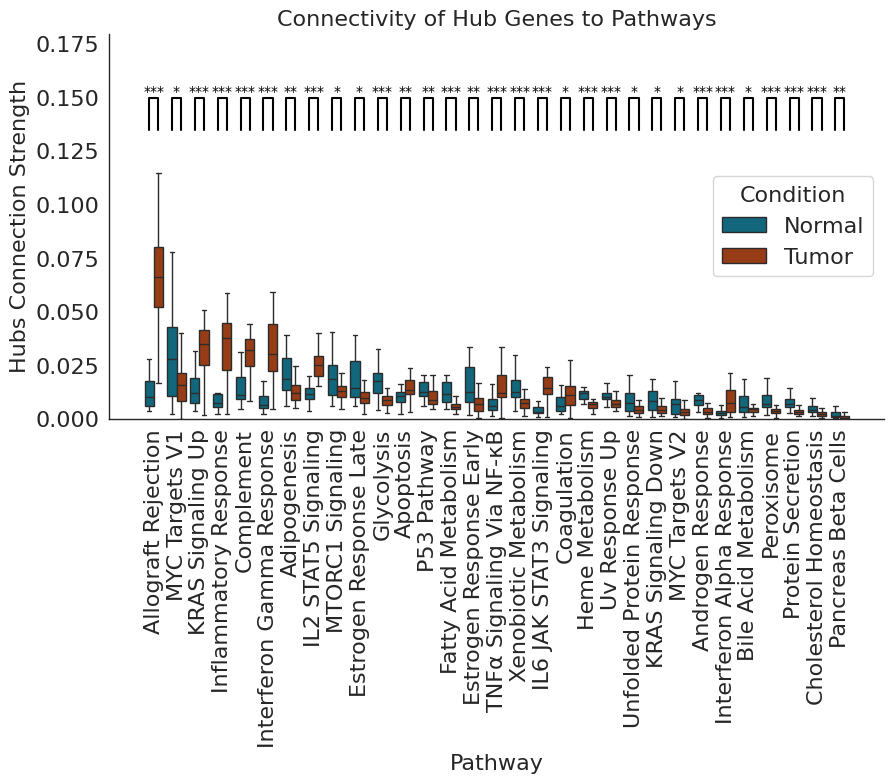

In [89]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plot_pathway_connectivity_reduced(connect, pvals, top_N=100, significance=0.05, ax=ax) # there are 50 hallmarks, 31 have significant differences

labels = [tick.get_text() for tick in ax.get_xticklabels()]
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in labels]

# Mapping for special gene/acronym capitalization
replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',   # already uppercase but just in case
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'MTORC1',
    ' Dn': ' Down'
}

for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

ax.set_xticklabels(labels)
plt.show()

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

# Generate column names based on the metric
tumor_col = 'f_degree_tumor'
normal_col = 'f_degree_normal'

# Convert columns to numeric (ensuring proper conversion)
df[tumor_col] = pd.to_numeric(df[tumor_col], errors='coerce')
df[normal_col] = pd.to_numeric(df[normal_col], errors='coerce')

# Init Tumor Hubs DataFrame
tumor_hub_values = df[tumor_col].dropna().unique()  # Drop NaNs before sorting
tumor_hub_df = pd.DataFrame(index=sorted(tumor_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

# Init Normal Hubs DataFrame
normal_hub_values = df[normal_col].dropna().unique()  # Drop NaNs before sorting
normal_hub_df = pd.DataFrame(index=sorted(normal_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

# Init All Hubs DataFrame
all_hub_values = set(normal_hub_values).union(tumor_hub_values)
all_hub_df = pd.DataFrame(index=sorted(all_hub_values, reverse=True), columns=['Tumor', 'Normal', 'Both'])

# Prepare Tumor Hubs DataFrame
for value in tumor_hub_df.index:
    tumor_hub_df.loc[value, 'CCIs'] = ((df[tumor_col] >= value) & (df['interactor'] == 1)).sum()
    tumor_hub_df.loc[value, 'Other Genes'] = ((df[tumor_col] >= value) & (df['interactor'] == 0)).sum()

# Prepare Normal Hubs DataFrame
for value in normal_hub_df.index:
    normal_hub_df.loc[value, 'CCIs'] = ((df[normal_col] >= value) & (df['interactor'] == 1)).sum()
    normal_hub_df.loc[value, 'Other Genes'] = ((df[normal_col] >= value) & (df['interactor'] == 0)).sum()

# Prepare All Hubs DataFrame
for value in all_hub_df.index:
    all_hub_df.loc[value, 'Both'] = ((df[normal_col] >= value) & (df[tumor_col] >= value)).sum()
    all_hub_df.loc[value, 'Normal'] = (df[normal_col] >= value).sum() - all_hub_df.loc[value, 'Both']
    all_hub_df.loc[value, 'Tumor'] = (df[tumor_col] >= value).sum() - all_hub_df.loc[value, 'Both']

# Normalize frequencies in Tumor and Normal Hubs DataFrame
tumor_hub_df = tumor_hub_df.div(tumor_hub_df.sum(axis=1), axis=0)
normal_hub_df = normal_hub_df.div(normal_hub_df.sum(axis=1), axis=0)

# Ensure all values are numeric
tumor_hub_df = tumor_hub_df.astype(np.float64)
normal_hub_df = normal_hub_df.astype(np.float64)
all_hub_df = all_hub_df.astype(np.float64)

# Define x values
normal_hub_x = normal_hub_df.index
tumor_hub_x = tumor_hub_df.index
all_hub_x = all_hub_df.index

# Get most common tumor and normal hubs
#tmax_str = '\n'.join(df[df.f_degree_tumor == df.f_degree_tumor.max()].index)
#nmax_str = '\n'.join(df[df.f_degree_normal == df.f_degree_normal.max()].index)

tmax_str = '  SASH3\nNCKAP1L'
nmax_str = 'RPL27A\n RPL19'

# FULL FIGURE

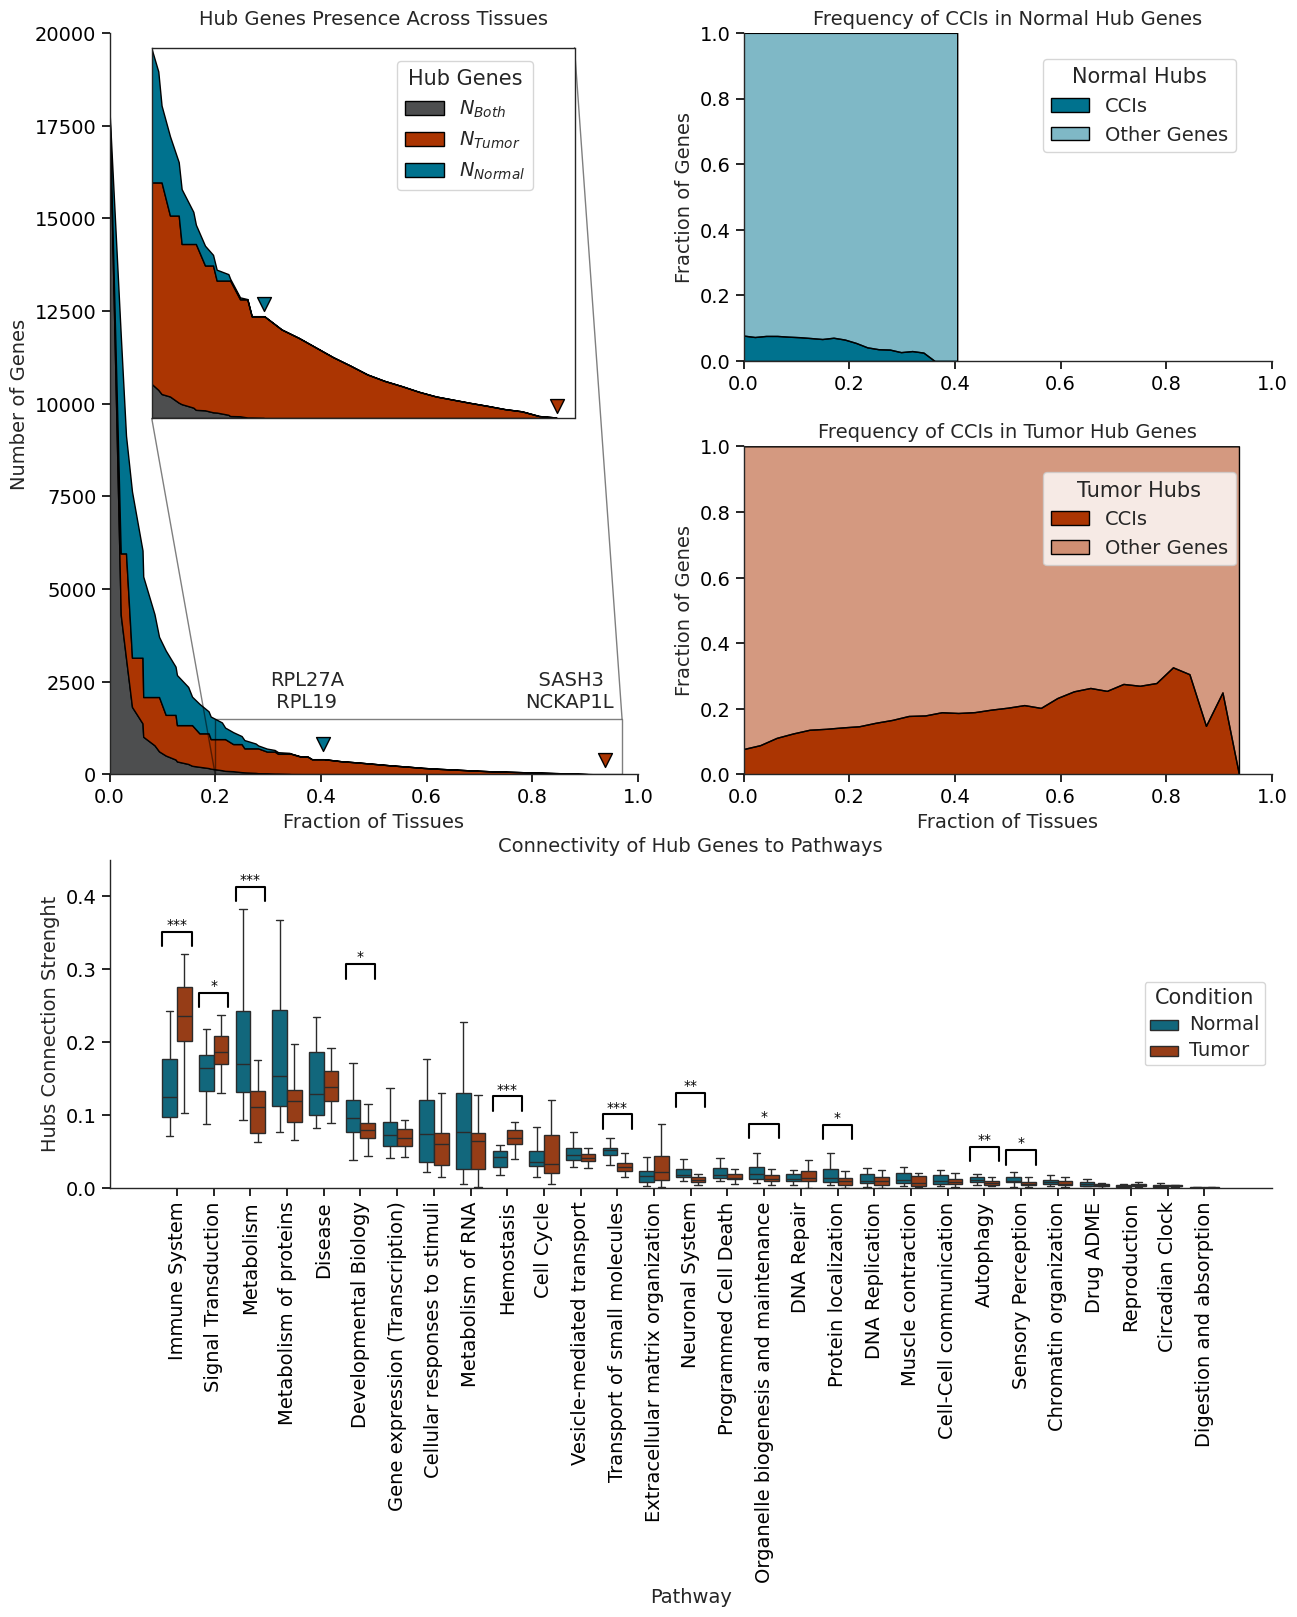

In [23]:
# HUBS FULL FIGURE

fs = 14

# Create the figure and the layout
fig = plt.figure(figsize=(15, 15))
axs = fig.subplot_mosaic(
    """
    AB
    AC
    DD
    """
)

# Plot All Hubs using plt.stackplot
axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)

tumor_max = all_hub_df.query('Tumor != 0').index.max()
normal_max = all_hub_df.query('Normal != 0').index.max()

#axs['A'].vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axs['A'].vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')
axs['A'].scatter(x=normal_max, y=400+all_hub_df.loc[normal_max].sum(), color=ncolor, s=100, marker='v', edgecolor='k')
axs['A'].scatter(x=tumor_max, y=400+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=100, marker='v', edgecolor='k')
axs['A'].text(x=normal_max-0.1, y=1800, s=nmax_str, fontsize=fs)
axs['A'].text(x=tumor_max-0.15, y=1800, s=tmax_str, fontsize=fs)
axs['A'].set_ylabel('Number of Genes', fontsize=fs)
axs['A'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['A'].grid(False)

# Add zoom

# subregion of the original image
x1, x2 = 0.2, 0.97,
y1, y2 = 0, 1500
    
axins = axs['A'].inset_axes(
    [0.08, 0.48, 0.8, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
axins.scatter(x=normal_max, y=50+all_hub_df.loc[normal_max].sum(), color=ncolor, s=100, marker='v', edgecolor='k')
axins.scatter(x=tumor_max, y=50+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=100, marker='v', edgecolor='k')
#axins.vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axins.vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')

axs['A'].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# Plot Normal Hubs using plt.stackplot
axs['B'].stackplot(normal_hub_x, normal_hub_df['CCIs'], normal_hub_df['Other Genes'],
              colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
axs['B'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['B'].grid(False)

# Plot Tumor Hubs using plt.stackplot
axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCIs'], tumor_hub_df['Other Genes'],
              colors=[tcolor, tcolor2], edgecolor='black')
axs['C'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['C'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['C'].grid(False)

# Plot pathways barplots
plot_pathway_connectivity(connect, pvals, ax=axs['D'])
#plot_pathway_connectivity(
#    connect,
#    pvals,
#    #top_N=20,
#    #significance=0.05
#)

# Adjust layout to remove space between plots
# plt.tight_layout()

# Add legends
loc = 'upper right'
axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='Hub Genes', bbox_to_anchor=(0.82, 0.975), loc=loc, fontsize=fs)
axs['B'].legend(['CCIs', 'Other Genes'], title='Normal Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['C'].legend(['CCIs', 'Other Genes'], title='Tumor Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['D'].legend(title='Condition', loc='center right')


axs['A'].set_xlim(0, 1)
axs['B'].set_xlim(0, 1)
axs['C'].set_xlim(0, 1)

axs['A'].set_ylim(0, 20000)
axs['B'].set_ylim(0, 1.)
axs['C'].set_ylim(0, 1.)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)

    axs[ax].xaxis.set_ticks_position('bottom')
    axs[ax].yaxis.set_ticks_position('left')
    axs[ax].get_xaxis().set_visible(True)
    axs[ax].get_yaxis().set_visible(True)

    axs[ax].tick_params(
        axis='both',
        which='both',
        labelsize=fs,
        direction='out',
        length=6,
        width=1.2,
        colors='black'
    )

axs['A'].set_title('Hub Genes Presence Across Tissues', fontsize=fs)
axs['B'].set_title('Frequency of CCIs in Normal Hub Genes', fontsize=fs)
axs['C'].set_title('Frequency of CCIs in Tumor Hub Genes', fontsize=fs)
axs['D'].set_title('Connectivity of Hub Genes to Pathways', fontsize=fs)

legend = axs['D'].get_legend()
axs['D'].set_xlabel('Pathway', fontsize=fs)
axs['D'].set_ylabel('Hubs Connection Strenght', fontsize=fs)

if legend:
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())
        text.set_fontsize(fs)

fig.subplots_adjust(hspace=0.26)  # Increase the vertical spacing between subplots
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/fig3.png', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/fig3.png', bbox_inches='tight', dpi=300)
plt.show()

In [24]:
fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels')

Saved panel 'Hub Genes Presence Across Tissues' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/hub_genes_presence_across_tissues
Saved panel 'Frequency of CCIs in Normal Hub Genes' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/frequency_of_ccis_in_normal_hub_genes
Saved panel 'Frequency of CCIs in Tumor Hub Genes' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/frequency_of_ccis_in_tumor_hub_genes
Saved panel 'Connectivity of Hub Genes to Pathways' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/connectivity_of_hub_genes_to_pathways


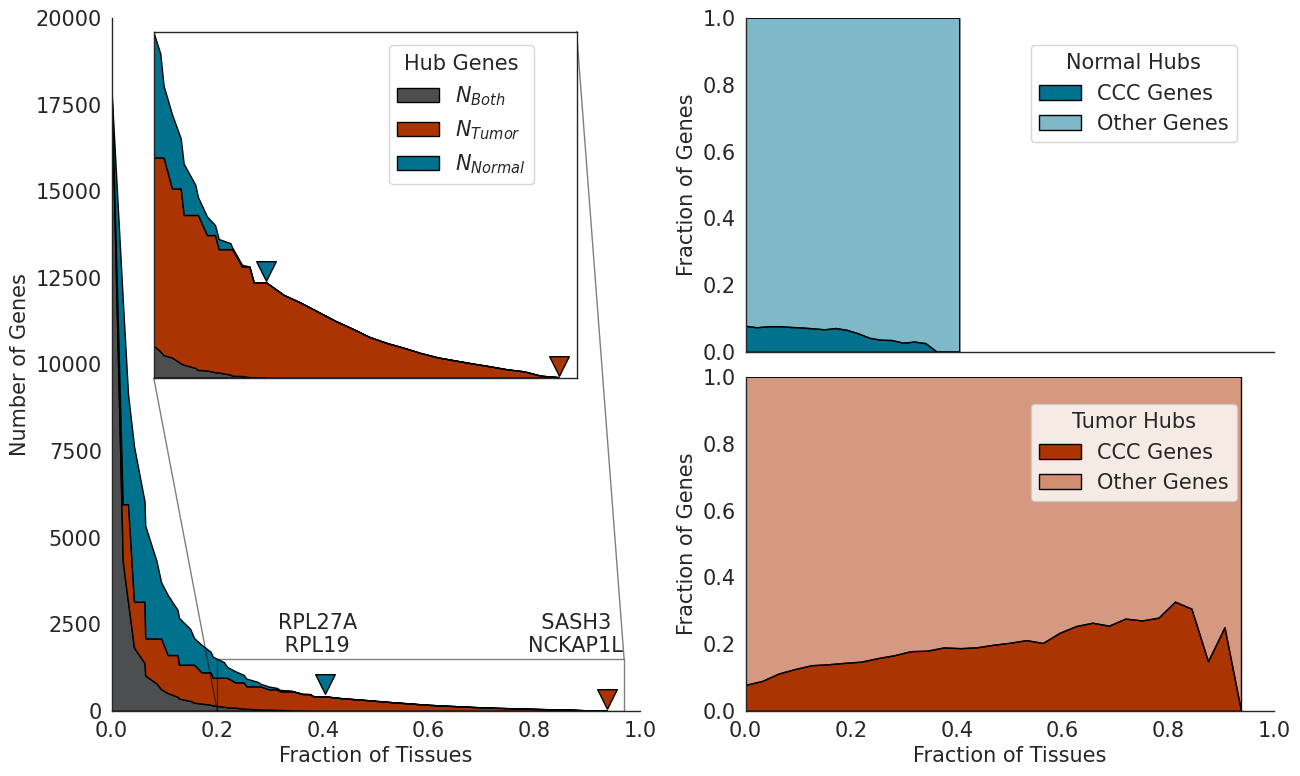

In [322]:
# HUBS FULL FIGURE

fs = 15

# Create the figure and the layout
fig = plt.figure(figsize=(15, 9))
axs = fig.subplot_mosaic(
    """
    AB
    AC
    """
)

# Plot All Hubs using plt.stackplot
axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)

tumor_max = all_hub_df.query('Tumor != 0').index.max()
normal_max = all_hub_df.query('Normal != 0').index.max()

#axs['A'].vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axs['A'].vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')
axs['A'].scatter(x=normal_max, y=325+all_hub_df.loc[normal_max].sum(), color=ncolor, s=200, marker='v', edgecolor='k')
axs['A'].scatter(x=tumor_max, y=325+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=200, marker='v', edgecolor='k')
axs['A'].text(x=normal_max-0.09, y=1700, s=nmax_str, fontsize=fs)
axs['A'].text(x=tumor_max-0.15, y=1700, s=tmax_str, fontsize=fs)
axs['A'].set_ylabel('Number of Genes', fontsize=fs)
axs['A'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['A'].grid(False)

# Add zoom

# subregion of the original image
x1, x2 = 0.2, 0.97,
y1, y2 = 0, 1500
    
axins = axs['A'].inset_axes(
    [0.08, 0.48, 0.8, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
axins.scatter(x=normal_max, y=50+all_hub_df.loc[normal_max].sum(), color=ncolor, s=200, marker='v', edgecolor='k')
axins.scatter(x=tumor_max, y=50+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=200, marker='v', edgecolor='k')
#axins.vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axins.vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')

axs['A'].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# Plot Normal Hubs using plt.stackplot
axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
              colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
axs['B'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['B'].grid(False)

# Plot Tumor Hubs using plt.stackplot
axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
              colors=[tcolor, tcolor2], edgecolor='black')
axs['C'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['C'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['C'].grid(False)

# Add legends
loc = 'upper right'
axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='Hub Genes', bbox_to_anchor=(0.82, 0.975), loc=loc, fontsize=fs)
axs['B'].legend(['CCIs', 'Other Genes'], title='Normal Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['C'].legend(['CCIs', 'Other Genes'], title='Tumor Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)


axs['A'].set_xlim(0, 1)
axs['B'].set_xlim(0, 1)
axs['C'].set_xlim(0, 1)

axs['A'].set_ylim(0, 20000)
axs['B'].set_ylim(0, 1.)
axs['C'].set_ylim(0, 1.)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)
    
fig.subplots_adjust(hspace=0.075)  # Increase the vertical spacing between subplots
axs['B'].set_xticks([])

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_subset_figure.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_subset_figure.png', bbox_inches='tight')
plt.show()